Source: https://github.com/explainingai-code/StableDiffusion-PyTorch/tree/main

# Import

In [1]:
# %pip install pytorch-lightning

In [2]:
import numpy as np
from tqdm.notebook import tqdm

In [3]:
import pytorch_lightning as pl

In [4]:
import os
import glob
import random

from PIL import Image

In [5]:
from collections import namedtuple
from torchvision.utils import make_grid

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets
from torchvision.models import VGG16_Weights

# LPIPS Loss

In [7]:
class VGG16(torch.nn.Module):
    def __init__(self, requires_grad=False):
        super().__init__()
        # Load pretrained vgg model from torchvision
        vgg_pretrained_features = torchvision.models.vgg16(
            weights=VGG16_Weights.IMAGENET1K_V1
        ).features
        self.slice1 = torch.nn.Sequential()
        self.slice2 = torch.nn.Sequential()
        self.slice3 = torch.nn.Sequential()
        self.slice4 = torch.nn.Sequential()
        self.slice5 = torch.nn.Sequential()
        self.N_slices = 5
        for x in range(4):
            self.slice1.add_module(str(x), vgg_pretrained_features[x])
        for x in range(4, 9):
            self.slice2.add_module(str(x), vgg_pretrained_features[x])
        for x in range(9, 16):
            self.slice3.add_module(str(x), vgg_pretrained_features[x])
        for x in range(16, 23):
            self.slice4.add_module(str(x), vgg_pretrained_features[x])
        for x in range(23, 30):
            self.slice5.add_module(str(x), vgg_pretrained_features[x])

        # Freeze vgg model
        if not requires_grad:
            for param in self.parameters():
                param.requires_grad = False

    def forward(self, X):
        # Return output of vgg features
        h = self.slice1(X)
        h_relu1_2 = h
        h = self.slice2(h)
        h_relu2_2 = h
        h = self.slice3(h)
        h_relu3_3 = h
        h = self.slice4(h)
        h_relu4_3 = h
        h = self.slice5(h)
        h_relu5_3 = h
        vgg_outputs = namedtuple("VggOutputs", ['relu1_2', 'relu2_2', 'relu3_3', 'relu4_3', 'relu5_3'])
        out = vgg_outputs(h_relu1_2, h_relu2_2, h_relu3_3, h_relu4_3, h_relu5_3)
        return out

In [8]:
class NetLinLayer(nn.Module):
    """A single linear layer which does a 1x1 conv"""
    def __init__(self, in_channels: int, out_channels: int = 1, use_dropout: bool = False):
        super().__init__()

        self.model = nn.Sequential(
            nn.Dropout() if use_dropout else nn.Identity(),
            nn.Conv2d(in_channels, out_channels, 1, stride=1, padding=0, bias=False),
        )

    def forward(self, x):
        out = self.model(x)
        return out

In [9]:
class ScalingLayer(nn.Module):
    def __init__(self):
        super(ScalingLayer, self).__init__()
        # Imagnet normalization for (0-1)
        # mean = [0.485, 0.456, 0.406]
        # std = [0.229, 0.224, 0.225]
        self.register_buffer('shift', torch.Tensor([-.030, -.088, -.188])[None, :, None, None])
        self.register_buffer('scale', torch.Tensor([.458, .448, .450])[None, :, None, None])
    
    def forward(self, inputs):
        return (inputs - self.shift) / self.scale

In [10]:
class LPIPS(nn.Module):
    def __init__(
        self,
        use_dropout: bool = True,
        state_dict_path: str = None,
    ):
        super().__init__()
        # Imagenet normalization
        self.vgg = VGG16()
        self.scaling_layer = ScalingLayer()

        # Instantiate vgg model
        self.channels = [64, 128, 256, 512, 512]
        self.L = len(self.channels)

        # Add 1x1 convolutional Layers
        self.lins = nn.ModuleList([
            NetLinLayer(channel, 1, use_dropout=use_dropout)
            for channel in self.channels
        ])

        self.avg_pooling = nn.AdaptiveAvgPool2d((1, 1))

        # Load the weights of trained LPIPS model
        if state_dict_path:
            sd = torch.load(state_dict_path, map_location='cpu')
            self.lins[0].load_state_dict({'model.1.weight': sd['lin0.model.1.weight']})
            self.lins[1].load_state_dict({'model.1.weight': sd['lin1.model.1.weight']})
            self.lins[2].load_state_dict({'model.1.weight': sd['lin2.model.1.weight']})
            self.lins[3].load_state_dict({'model.1.weight': sd['lin3.model.1.weight']})
            self.lins[4].load_state_dict({'model.1.weight': sd['lin4.model.1.weight']})

            # Freeze all parameters
            self.eval()
            for param in self.parameters():
                param.requires_grad = False

            for lin in self.lins:
                print((lin.model[1].weight < 0).sum())

    def forward(self, inputs_0, inputs_1, normalize: bool = False):
        # Scale the inputs to -1 to +1 range if needed
        if normalize:  # turn on this flag if input is [0,1] so it can be adjusted to [-1, +1]
            inputs_0 = 2 * inputs_0 - 1
            inputs_1 = 2 * inputs_1 - 1

        # Normalize the inputs according to imagenet normalization
        inputs_0, inputs_1 = self.scaling_layer(inputs_0), self.scaling_layer(inputs_1)

        # Get VGG outputs for image0 and image1
        outs_0, outs_1 = self.vgg(inputs_0), self.vgg(inputs_1)
        feats_0, feats_1, diffs = {}, {}, {}

        # Compute Square of Difference for each layer output
        for kk in range(self.L):
            feats_0[kk], feats_1[kk] = F.normalize(outs_0[kk], dim=1), F.normalize(outs_1[kk], dim=1)
            diffs[kk] = (feats_0[kk] - feats_1[kk]) ** 2

        # 1x1 convolution followed by spatial average on the square differences
        res = [
            # [batch_size, channels[i], 1, 1]
            self.avg_pooling(self.lins[kk](diffs[kk]))
            for kk in range(self.L)
        ]

        # Aggregate the results of each layer
        val = sum(res)

        return val

https://github.com/richzhang/PerceptualSimilarity/blob/master/lpips/weights/v0.1/vgg.pth

In [11]:
lpips = LPIPS(state_dict_path='vgg.pth')

tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)


In [12]:
x = torch.ones(32, 1, 28, 28)

In [13]:
lpips(x, torch.randn_like(x)).shape

torch.Size([32, 1, 1, 1])

# Model

## UNet blocks

In [14]:
class TimeEmbedding(nn.Module):
    def __init__(
        self,
        t_emb_dim: int,
    ):
        super().__init__()
        assert t_emb_dim % 2 == 0, "time embedding dimension must be divisible by 2"
        self.t_emb_dim = t_emb_dim
        self.half_t_emb_dim = t_emb_dim // 2

        factor = 10_000 ** (
            (
                torch.arange(start=0, end=self.half_t_emb_dim, dtype=torch.float32)
                 / (self.half_t_emb_dim)
            )
        )
        self.register_buffer('factor', factor, persistent=False)

    def forward(self, time_steps: torch.Tensor) -> torch.Tensor:
        t_emb = time_steps[:, None].repeat(1, self.half_t_emb_dim) / self.factor
        t_emb = torch.cat([torch.sin(t_emb), torch.cos(t_emb)], dim=-1)
        return t_emb

In [15]:
class ConvNormBlock(nn.Module):
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        norm_channels: int,
        kernel_size: int,
        stride: int,
        padding: int,
    ):
        super().__init__()

        self.model = nn.Sequential(
            nn.GroupNorm(norm_channels, in_channels),
            nn.SiLU(),
            nn.Conv2d(
                in_channels,
                out_channels,
                kernel_size=kernel_size,
                stride=stride,
                padding=padding,
            ),
        )

    def forward(self, inputs: torch.Tensor) -> torch.Tensor:
        return self.model(inputs)

In [16]:
class AttentionNormBlock(nn.Module):
    def __init__(
        self,
        num_heads: int,
        norm_channels: int,
        out_channels: int,
    ):
        super().__init__()
        self.norm_attn = nn.GroupNorm(norm_channels, out_channels)
        self.attn = nn.MultiheadAttention(out_channels, num_heads, batch_first=True)

    def forward(self, inputs: torch.Tensor) -> torch.Tensor:
        batch_size, channels, h, w = inputs.shape
        out = inputs.reshape(batch_size, channels, h * w)
        out = self.norm_attn(out).transpose(1, 2)
        out_attn, _ = self.attn(out, out, out)
        out_attn = out_attn.transpose(1, 2).reshape(batch_size, channels, h, w)
        return out_attn + inputs

In [17]:
class CrossAttention(nn.Module):
    def __init__(
        self,
        context_dim: int,
        num_heads: int,
        norm_channels: int,
        out_channels: int,
    ):
        super().__init__()
        self.norm_attn = nn.GroupNorm(norm_channels, out_channels)
        self.attn = nn.MultiheadAttention(out_channels, num_heads, batch_first=True)
        self.context_proj = nn.Linear(context_dim, out_channels)

    def forward(self, inputs: torch.Tensor, context: torch.Tensor) -> torch.Tensor:
        batch_size, channels, h, w = inputs.shape
        out = inputs.reshape(batch_size, channels, h * w)
        out = self.norm_attn(out).transpose(1, 2)

        context_proj = self.context_proj(context)
        out_attn, _ = self.attn(out, context_proj, context_proj)
        out_attn = out_attn.transpose(1, 2).reshape(batch_size, channels, h, w)
        return out_attn + inputs

In [18]:
class ResNetConvNormBlock(nn.Module):
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        t_emb_dim: int,
        norm_channels: int,
        kernel_size: int,
        stride: int,
        padding: int,
    ):
        super().__init__()
        self.t_emb_dim = t_emb_dim

        self.resnet_conv_first = ConvNormBlock(
            in_channels,
            out_channels,
            norm_channels,
            kernel_size=kernel_size,
            stride=stride,
            padding=padding,
        )
        if t_emb_dim is not None:
            self.t_emb_layers = nn.Sequential(
                nn.SiLU(),
                nn.Linear(t_emb_dim, out_channels)
            )
        self.resnet_conv_second = ConvNormBlock(
            out_channels,
            out_channels,
            norm_channels,
            kernel_size=kernel_size,
            stride=stride,
            padding=padding,
        )
        self.residual_input_conv = nn.Conv2d(
            in_channels,
            out_channels,
            kernel_size=1,
        )

    def forward(self, inputs: torch.Tensor, t_emb: torch.Tensor = None):
        out = self.resnet_conv_first(inputs)
        if self.t_emb_dim is not None:
            out = out + self.t_emb_layers(t_emb)[:, :, None, None]
        return self.resnet_conv_second(out) + self.residual_input_conv(inputs)

In [19]:
class DownBlock(nn.Module):
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        t_emb_dim: int,
        down_sample: bool,
        num_heads: int,
        num_layers: int,
        attn: bool,
        norm_channels: int,
        cross_attn: bool = False,
        context_dim: int = None,
    ):
        super().__init__()
        self.num_layers = num_layers
        self.down_sample = down_sample
        self.attn = attn
        self.cross_attn = cross_attn
        self.t_emb_dim = t_emb_dim

        self.resnet_conv_blocks = nn.ModuleList(
            [
                ResNetConvNormBlock(
                    in_channels if i == 0 else out_channels,
                    out_channels,
                    t_emb_dim,
                    norm_channels,
                    kernel_size=3,
                    stride=1,
                    padding=1,
                )
                for i in range(num_layers)
            ]
        )

        if self.attn:
            self.attentions = nn.ModuleList(
                [
                    AttentionNormBlock(num_heads, norm_channels, out_channels)
                    for _ in range(num_layers)
                ]
            )

        if self.cross_attn:
            self.cross_attentions = nn.ModuleList(
                [
                    CrossAttention(context_dim, num_heads, norm_channels, out_channels)
                    for _ in range(num_layers)
                ]
            )

        self.down_sample_conv = nn.Conv2d(
            out_channels,
            out_channels,
            kernel_size=4,
            stride=2,
            padding=1,
        ) if self.down_sample else nn.Identity()

    def forward(self, inputs: torch.Tensor, t_emb: torch.Tensor = None, context: torch.Tensor = None):
        out = inputs
        for i in range(self.num_layers):
            # Resnet block of Unet
            out = self.resnet_conv_blocks[i](out, t_emb)

            if self.attn:
                # Attention block of Unet
                out = self.attentions[i](out)

            if self.cross_attn:
                out = self.cross_attentions[i](out, context)

        # Downsample
        out = self.down_sample_conv(out)
        return out

In [20]:
class MidBlock(nn.Module):
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        t_emb_dim: int,
        num_heads: int,
        num_layers: int,
        norm_channels: int,
        cross_attn: bool = False,
        context_dim: int = None,
    ):
        super().__init__()
        self.num_layers = num_layers
        self.t_emb_dim = t_emb_dim
        self.cross_attn = cross_attn

        self.resnet_conv_blocks = nn.ModuleList(
            [
                ResNetConvNormBlock(
                    in_channels if i == 0 else out_channels,
                    out_channels,
                    t_emb_dim,
                    norm_channels,
                    kernel_size=3,
                    stride=1,
                    padding=1,
                )
                for i in range(num_layers + 1)
            ]
        )

        self.attentions = nn.ModuleList(
            [
                AttentionNormBlock(num_heads, norm_channels, out_channels)
                for _ in range(num_layers)
            ]
        )

        if self.cross_attn:
            self.cross_attentions = nn.ModuleList(
                [
                    CrossAttention(context_dim, num_heads, norm_channels, out_channels)
                    for _ in range(num_layers)
                ]
            )

    def forward(self, inputs: torch.Tensor, t_emb: torch.Tensor = None, context: torch.Tensor = None):
        out = inputs
        # First resnet block
        out = self.resnet_conv_blocks[0](out, t_emb)

        for i in range(self.num_layers):
            # Attention Block
            out = self.attentions[i](out)

            if self.cross_attn:
                out = self.cross_attentions[i](out, context)

            # Resnet Block
            out = self.resnet_conv_blocks[i + 1](out, t_emb)

        return out

In [21]:
class UpBlock(nn.Module):
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        t_emb_dim: int,
        up_sample: bool,
        num_heads: int,
        num_layers: int,
        attn: bool,
        norm_channels: int,
        concat_with_down: bool = False,
        cross_attn: bool = False,
        context_dim: int = None,
    ):
        super().__init__()
        self.num_layers = num_layers
        self.up_sample = up_sample
        self.t_emb_dim = t_emb_dim
        self.attn = attn
        self.cross_attn = cross_attn

        self.resnet_conv_blocks = nn.ModuleList(
            [
                ResNetConvNormBlock(
                    in_channels if i == 0 else out_channels,
                    out_channels,
                    t_emb_dim,
                    norm_channels,
                    kernel_size=3,
                    stride=1,
                    padding=1,
                )
                for i in range(num_layers)
            ]
        )

        if self.attn:
            self.attentions = nn.ModuleList(
              [
                  AttentionNormBlock(num_heads, norm_channels, out_channels)
                  for _ in range(num_layers)
              ]
          )

        if self.cross_attn:
            self.cross_attentions = nn.ModuleList(
                [
                    CrossAttention(context_dim, num_heads, norm_channels, out_channels)
                    for _ in range(num_layers)
                ]
            )

        self.up_sample_conv = nn.ConvTranspose2d(
            in_channels // 2 if concat_with_down else in_channels,
            in_channels // 2 if concat_with_down else in_channels,
            kernel_size=4,
            stride=2,
            padding=1,
        ) if self.up_sample else nn.Identity()

    def forward(self, inputs: torch.Tensor, out_down: torch.Tensor = None, t_emb: torch.Tensor = None, context: torch.Tensor = None):
        # Upsample
        inputs = self.up_sample_conv(inputs)

        # Concat with Downblock output
        if out_down is not None:
            inputs = torch.cat([inputs, out_down], dim=1)

        out = inputs
        for i in range(self.num_layers):
            # Resnet Block
            out = self.resnet_conv_blocks[i](out, t_emb)

            # Self Attention
            if self.attn:
                out = self.attentions[i](out)

            if self.cross_attn:
                out = self.cross_attentions[i](out, context)
        return out

## VQVAE

In [22]:
class VAEEncoder(nn.Module):
    def __init__(
        self,
        im_channels: int,
        down_channels: list,
        down_sample: list,
        num_heads: int,
        num_down_layers: int,
        attns: list,
        norm_channels: int,
        mid_channels: list,
        num_mid_layers: int,
        z_channels: int,
    ):
        super().__init__()

        self.encoder_conv_in = nn.Conv2d(
            im_channels,
            down_channels[0],
            kernel_size=3,
            padding=(1, 1),
        )

        self.encoder_downs = nn.ModuleList([
            DownBlock(
                down_channels[i],
                down_channels[i + 1],
                t_emb_dim=None,
                down_sample=down_sample[i],
                num_heads=num_heads,
                num_layers=num_down_layers,
                attn=attns[i],
                norm_channels=norm_channels,
            )
            for i in range(len(down_channels) - 1)
        ])

        self.encoder_mids = nn.ModuleList([
            MidBlock(
                mid_channels[i],
                mid_channels[i + 1],
                t_emb_dim=None,
                num_heads=num_heads,
                num_layers=num_mid_layers,
                norm_channels=norm_channels,
            )
            for i in range(len(mid_channels) - 1)
        ])

        self.encoder_out = nn.Sequential(
            nn.GroupNorm(norm_channels, down_channels[-1]),
            nn.SiLU(),
            nn.Conv2d(down_channels[-1], z_channels, kernel_size=3, padding=1),
        )

    def forward(self, inputs: torch.Tensor):
        out = self.encoder_conv_in(inputs)
        # print(out.shape)
        for i, down in enumerate(self.encoder_downs):
            out = down(out)
            # print('d', out.shape)
        for i, mid in enumerate(self.encoder_mids):
            out = mid(out)
            # print('m', out.shape)
        out = self.encoder_out(out)
        # print(out.shape)
        # print('---')
        return out

In [23]:
class VAEDecoder(nn.Module):
    def __init__(
        self,
        im_channels: int,
        down_channels: list,
        down_sample: list,
        num_heads: int,
        num_up_layers: int,
        attns: list,
        norm_channels: int,
        mid_channels: list,
        num_mid_layers: int,
        z_channels: int,
    ):
        super().__init__()

        self.decoder_conv_in = nn.Conv2d(
            z_channels,
            mid_channels[-1],
            kernel_size=3,
            padding=(1, 1),
        )

        self.decoder_mids = nn.ModuleList([
            MidBlock(
                mid_channels[i],
                mid_channels[i - 1],
                t_emb_dim=None,
                num_heads=num_heads,
                num_layers=num_mid_layers,
                norm_channels=norm_channels,
            )
            for i in reversed(range(1, len(mid_channels)))
        ])

        self.decoder_ups = nn.ModuleList([
            UpBlock(
                down_channels[i],
                down_channels[i - 1],
                t_emb_dim=None,
                up_sample=down_sample[i - 1],
                num_heads=num_heads,
                num_layers=num_up_layers,
                attn=attns[i - 1],
                norm_channels=norm_channels,
            )
            for i in reversed(range(1, len(down_channels)))
        ])

        self.decoder_out = nn.Sequential(
            nn.GroupNorm(norm_channels, down_channels[0]),
            nn.SiLU(),
            nn.Conv2d(down_channels[0], im_channels, kernel_size=3, padding=1),
        )

    def forward(self, inputs: torch.Tensor):
        out = self.decoder_conv_in(inputs)
        # print(out.shape)
        for i, mid in enumerate(self.decoder_mids):
            out = mid(out)
            # print('m', out.shape)
        for i, up in enumerate(self.decoder_ups):
            out = up(out)
            # print('u', out.shape)
        out = self.decoder_out(out)
        # print(out.shape)
        return out

In [24]:
class VQVAE(nn.Module):
    def __init__(self, model_config):
        super().__init__()
        self.im_channels = model_config['im_channels']
        self.down_channels = model_config['down_channels']
        self.mid_channels = model_config['mid_channels']
        self.down_sample = model_config['down_sample']
        self.num_down_layers = model_config['num_down_layers']
        self.num_mid_layers = model_config['num_mid_layers']
        self.num_up_layers = model_config['num_up_layers']
        self.norm_channels = model_config['norm_channels']

        # To disable attention in Downblock of Encoder and Upblock of Decoder
        self.attns = model_config['attns_down']
        self.num_heads = model_config['num_heads']

        # Latent Dimension
        self.z_channels = model_config['z_channels']
        self.codebook_size = model_config['codebook_size']

        self.up_sample = model_config['up_sample']

        self.encoder = VAEEncoder(
            im_channels=self.im_channels,
            down_channels=self.down_channels,
            down_sample=self.down_sample,
            num_heads=self.num_heads,
            num_down_layers=self.num_down_layers,
            attns=self.attns,
            norm_channels=self.norm_channels,
            mid_channels=self.mid_channels,
            num_mid_layers=self.num_mid_layers,
            z_channels=self.z_channels,
        )
        self.decoder = VAEDecoder(
            im_channels=self.im_channels,
            down_channels=self.down_channels,
            down_sample=self.down_sample,
            num_heads=self.num_heads,
            num_up_layers=self.num_up_layers,
            attns=self.attns,
            norm_channels=self.norm_channels,
            mid_channels=self.mid_channels,
            num_mid_layers=self.num_mid_layers,
            z_channels=self.z_channels,
        )

        # Codebook
        self.embedding = nn.Embedding(self.codebook_size, self.z_channels)
        # Pre Quantization Convolution
        self.pre_quant_conv = nn.Conv2d(self.z_channels, self.z_channels, kernel_size=1)
        # Post Quantization Convolution
        self.post_quant_conv = nn.Conv2d(self.z_channels, self.z_channels, kernel_size=1)

    def quantize(self, x: torch.Tensor):
        B, C, H, W = x.shape

        # B, C, H, W -> B, H, W, C
        x = x.permute(0, 2, 3, 1)

        # B, H, W, C -> B, H*W, C
        x = x.reshape(B, -1, C)

        # Find nearest embedding/codebook vector
        # dist between (B, H*W, C) and (B, K, C) -> (B, H*W, K)
        dist = torch.cdist(x, self.embedding.weight[None, :].repeat((x.size(0), 1, 1)))
        # (B, H*W)
        min_encoding_indices = torch.argmin(dist, dim=-1)

        # Replace encoder output with nearest codebook
        # quant_out -> B*H*W, C
        quant_out = torch.index_select(self.embedding.weight, 0, min_encoding_indices.view(-1))

        # x -> B*H*W, C
        x = x.reshape((-1, x.size(-1)))
        commmitment_loss = torch.mean((quant_out.detach() - x) ** 2)
        codebook_loss = torch.mean((quant_out - x.detach()) ** 2)
        quantize_losses = {
            'codebook_loss': codebook_loss,
            'commitment_loss': commmitment_loss
        }
        # Straight through estimation
        quant_out = x + (quant_out - x).detach()

        # quant_out -> B, C, H, W
        quant_out = quant_out.reshape((B, H, W, C)).permute(0, 3, 1, 2)
        min_encoding_indices = min_encoding_indices.reshape((-1, quant_out.size(-2), quant_out.size(-1)))
        return quant_out, quantize_losses, min_encoding_indices

    def encode(self, x):
        out = self.encoder(x)
        out = self.pre_quant_conv(out)
        out, quant_losses, _ = self.quantize(out)
        return out, quant_losses

    def decode(self, z):
        out = z
        out = self.post_quant_conv(out)
        out = self.decoder(out)
        return out

    def forward(self, x):
        z, quant_losses = self.encode(x)
        out = self.decode(z)
        return out, z, quant_losses

## Discriminator

In [25]:
class Discriminator(nn.Module):
    """
    PatchGAN Discriminator.
    Rather than taking IMG_CHANNELSxIMG_HxIMG_W all the way to
    1 scalar value , we instead predict grid of values.
    Where each grid is prediction of how likely
    the discriminator thinks that the image patch corresponding
    to the grid cell is real
    """

    def __init__(
        self,
        im_channels=3,
        conv_channels=[64, 128, 256],
        kernels=[4,4,4,4],
        strides=[2,2,2,1],
        paddings=[1,1,1,1]
    ):
        super().__init__()
        self.im_channels = im_channels
        activation = nn.LeakyReLU(0.2)
        layers_dim = [self.im_channels] + conv_channels + [1]
        self.layers = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(
                    layers_dim[i],
                    layers_dim[i + 1],
                    kernel_size=kernels[i],
                    stride=strides[i],
                    padding=paddings[i],
                    bias=False if i != 0 else True
                ),
                nn.BatchNorm2d(
                    layers_dim[i + 1]
                ) if i != len(layers_dim) - 2 and i != 0 else nn.Identity(),
                activation if i != len(layers_dim) - 2 else nn.Identity(),
            )
            for i in range(len(layers_dim) - 1)
        ])

    def forward(self, x):
        out = x
        for layer in self.layers:
            out = layer(out)
        return out

## LDM

In [26]:
class LinearNoiseScheduler(nn.Module):
    def __init__(
        self,
        num_timesteps: int,
        beta_start: float,
        beta_end: float,
    ):
        super().__init__()
        self.num_timesteps = num_timesteps
        self.beta_start = beta_start
        self.beta_end = beta_end

        betas = torch.linspace(beta_start, beta_end, num_timesteps)
        alphas = (1.0 - betas)
        alpha_cum_prod = torch.cumprod(alphas, dim=0)
        sqrt_alpha_cum_prod = torch.sqrt(alpha_cum_prod)
        sqrt_one_minus_alpha_cum_prod = torch.sqrt(1 - alpha_cum_prod)

        self.register_buffer('betas', betas, persistent=False)
        self.register_buffer('alphas', alphas, persistent=False)
        self.register_buffer('alpha_cum_prod', alpha_cum_prod, persistent=False)
        self.register_buffer('sqrt_alpha_cum_prod', sqrt_alpha_cum_prod, persistent=False)
        self.register_buffer('sqrt_one_minus_alpha_cum_prod', sqrt_one_minus_alpha_cum_prod, persistent=False)

    def add_noise(self, original, noise: torch.Tensor, t) -> torch.Tensor:
        # original = [batch, n_ch, H, W]
        # t = [batch,]
        original_shape = original.shape
        batch_size = original_shape[0]

        sqrt_alpha_cum_prod = self.sqrt_alpha_cum_prod[t].reshape(batch_size)
        sqrt_one_minus_alpha_cum_prod = self.sqrt_one_minus_alpha_cum_prod[t].reshape(batch_size)

        for _ in range(len(original_shape) - 1):
            sqrt_alpha_cum_prod = sqrt_alpha_cum_prod.unsqueeze(-1)
        for _ in range(len(original_shape) - 1):
            sqrt_one_minus_alpha_cum_prod = sqrt_one_minus_alpha_cum_prod.unsqueeze(-1)

        return (
            sqrt_alpha_cum_prod * original + sqrt_one_minus_alpha_cum_prod * noise
        )

    def sample_prev_timestep(self, xt, noise_pred, t) -> tuple:
        x0 = ((xt - (self.sqrt_one_minus_alpha_cum_prod[t] * noise_pred)) / self.sqrt_alpha_cum_prod[t])
        x0 = torch.clamp(x0, -1.0, 1.0)

        mean = xt - ((self.betas[t]) * noise_pred) / (self.sqrt_one_minus_alpha_cum_prod[t])
        mean = mean / torch.sqrt(self.alphas[t])

        if t == 0:
            return mean, x0
        else:
            variance = (1 - self.alpha_cum_prod[t - 1]) / (1.0 - self.sqrt_alpha_cum_prod[t])
            variance = variance * self.betas[t]
            sigma = variance ** 0.5
            z = torch.randn_like(xt)
            return mean + sigma * z, x0

## Unet

### MNIST

In [27]:
class Unet2(nn.Module):
    def __init__(self, model_config: dict):
        super().__init__()
        in_channels = model_config['im_channels']
        self.down_channels = model_config['down_channels']
        self.mid_channels = model_config['mid_channels']
        self.t_emb_dim = model_config['t_emb_dim']
        self.down_sample = model_config['down_sample']
        self.num_down_layers = model_config['num_down_layers']
        self.num_mid_layers = model_config['num_mid_layers']
        self.num_up_layers = model_config['num_up_layers']
        self.attns = model_config['attns']
        self.norm_channels = model_config['norm_channels']
        self.num_heads = model_config['num_heads']
        self.conv_out_channels = model_config['conv_out_channels']
        self.context_dim = model_config['context_dim']

        self.time_emb = TimeEmbedding(self.t_emb_dim)
        self.t_proj = nn.Sequential(
            nn.Linear(self.t_emb_dim, self.t_emb_dim),
            nn.SiLU(),
            nn.Linear(self.t_emb_dim, self.t_emb_dim),
        )
        self.conv_in = nn.Conv2d(in_channels, self.down_channels[0], kernel_size=3, padding=1)
        self.downs = nn.ModuleList([
            DownBlock(
                self.down_channels[i],
                self.down_channels[i+1],
                self.t_emb_dim,
                down_sample=self.down_sample[i],
                num_heads=self.num_heads,
                attn=self.attns[i],
                num_layers=self.num_down_layers,
                norm_channels=self.norm_channels,
                cross_attn=True,
                context_dim=self.context_dim,
            ) for i in range(len(self.down_channels) - 1)
        ])
        self.mids = nn.ModuleList([
             MidBlock(
                self.mid_channels[i],
                self.mid_channels[i+1],
                self.t_emb_dim,
                num_heads=self.num_heads,
                num_layers=self.num_mid_layers,
                norm_channels=self.norm_channels,
                cross_attn=True,
                context_dim=self.context_dim,
            ) for i in range(len(self.mid_channels) - 1)
        ])
        self.ups = nn.ModuleList([
            UpBlock(
                self.down_channels[i] * 2,
                self.down_channels[i-1] if i != 0 else self.conv_out_channels,
                self.t_emb_dim,
                up_sample=self.down_sample[i],
                num_heads=self.num_heads,
                num_layers=self.num_up_layers,
                attn=self.attns[i],
                norm_channels=self.norm_channels,
                concat_with_down=True,
                cross_attn=True,
                context_dim=self.context_dim,
            ) for i in reversed(range(len(self.down_channels) - 1))
        ])
        self.unet_out = nn.Sequential(
            nn.GroupNorm(self.norm_channels, self.conv_out_channels),
            nn.SiLU(),
            nn.Conv2d(self.conv_out_channels, in_channels, kernel_size=3, padding=1)
        )

    def forward(self, x, t, context) -> torch.Tensor:
        out = self.conv_in(x)
        t_emb = self.time_emb(t)
        t_emb = self.t_proj(t_emb)

        down_outs = []
        for down in self.downs:
            down_outs.append(out)
            out = down(out, t_emb, context)

        for mid in self.mids:
            out = mid(out, t_emb, context)

        for up in self.ups:
            down_out = down_outs.pop()
            out = up(out, down_out, t_emb, context)

        out = self.unet_out(out)

        return out

# Lightning

## VQVAE trainer

In [28]:
class VQVAELightning(pl.LightningModule):
    def __init__(
        self,
        model,
        discriminator,
        lpips,
        lr: float,
        disct_start_step,
    ):
        super().__init__()
        self.model = model
        self.discriminator = discriminator
        self.lpips = lpips
        self.lr = lr
        self.disct_start_step = disct_start_step

        self.recon_criterion = nn.MSELoss()
        self.disc_criterion = nn.MSELoss()

        self.automatic_optimization = False

    def forward(self, x):
        return self.model(x)

    def evaluate_generator_loss(
        self,
        g_output,
        lpips_output,
        im,
        quantize_losses,
    ):
        recon_loss = 1.0 * self.recon_criterion(g_output, im)
        quantize_loss = 1.0 * quantize_losses["codebook_loss"] + 0.2 * quantize_losses["commitment_loss"]
        lpips_loss = 1.0 * torch.mean(lpips_output)

        g_loss = (
            recon_loss
            + quantize_loss
            + lpips_loss
        )

        if self.global_step > self.disct_start_step:
            disc_fake_pred = self.discriminator(g_output)
            disc_fake_loss = self.disc_criterion(
                disc_fake_pred,
                torch.ones_like(disc_fake_pred)
            )
            g_loss += 0.5 * disc_fake_loss

        return g_loss

    def evaluate_discriminator_loss(
        self,
        g_output,
        im,
    ):
        disc_fake_pred = self.discriminator(g_output.detach())
        disc_real_pred = self.discriminator(im)

        disc_fake_loss = self.disc_criterion(
            disc_fake_pred,
            torch.zeros_like(disc_fake_pred)
        )
        disc_real_loss = self.disc_criterion(
            disc_real_pred,
            torch.ones_like(disc_real_pred)
        )
        d_loss = 0.5 * (disc_fake_loss + disc_real_loss) / 2

        return d_loss

    def training_step(self, batch, batch_idx):
        output, z, quantize_losses = self.model(batch[0])
        lpips_output = self.lpips(output, batch[0])

        optimizer_g, optimizer_d = self.optimizers()
        # ???
        optimizer_g.zero_grad()
        optimizer_d.zero_grad()

        g_loss = self.evaluate_generator_loss(output, lpips_output, batch[0], quantize_losses)
        self.manual_backward(g_loss)
        optimizer_g.step()

        if self.global_step > self.disct_start_step:
            d_loss = self.evaluate_discriminator_loss(output, batch[0])
            self.manual_backward(d_loss)
            optimizer_d.step()
        else:
            d_loss = torch.tensor(-1)

        self.log("train_g_loss", g_loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.log("train_d_loss", d_loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return g_loss

    def configure_optimizers(self):
        betas = (0.5, 0.999)
        optimizer_g = torch.optim.AdamW(self.model.parameters(), lr=self.lr, betas=betas)
        optimizer_d = torch.optim.AdamW(self.discriminator.parameters(), lr=self.lr, betas=betas)
        return [optimizer_g, optimizer_d]

## LDM trainer

In [29]:
class DDPMLightning(pl.LightningModule):
    def __init__(
        self,
        unet_model,
        vae_model,
        text_encoder,
        noise_scheduler,
        criterion,
        lr: float,
    ):
        super().__init__()

        self.unet_model = unet_model
        self.vae_model = vae_model
        self.text_encoder = text_encoder
        self.noise_scheduler = noise_scheduler
        self.criterion = criterion
        self.lr = lr

    def forward(self, x):
        img, input_ids, attention_mask = x
        
        with torch.no_grad():
            img, _ = self.vae_model.encode(img)
            labels = self.text_encoder(
                input_ids=input_ids, attention_mask=attention_mask
            ).last_hidden_state
        
        noise = torch.randn_like(img)
        # print(noise.device)

        # Sample timestep
        t = torch.randint(0, self.noise_scheduler.num_timesteps, (img.shape[0],), device=img.device)

        # Add noise to images according to timestep
        noisy_im = self.noise_scheduler.add_noise(img, noise, t)
        noise_pred = self.unet_model(noisy_im, t, labels)
        return noise_pred, noise

    def evaluate(self, batch, mode: str):
        noise_pred, noise = self(batch)
        loss = self.criterion(noise_pred, noise)
        return loss

    def training_step(self, batch, batch_idx):
        train_loss = self.evaluate(batch, 'train')
        self.log("train_loss", train_loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return train_loss

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(
            self.unet_model.parameters(),
            lr=self.lr,
        )
        return optimizer

# Utils

In [30]:
def count_parameters(model: nn.Module):
    """Количество обучаемых параметров модели"""
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# MNIST

## Data Load

In [31]:
train_dataset = datasets.MNIST(
    root='mnist',
    train=True,
    transform=torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Lambda(lambda x: x * 2 - 1),
    ]),
    download=True,
)

In [32]:
class MNISTConditionDataset(Dataset):
    def __init__(self, mnist_dataset):
        super().__init__()
        self.mnist_dataset = mnist_dataset
        self.cond_drop_prob: float = 0.1

    def __getitem__(self, index: int) -> tuple:
        img, label = self.mnist_dataset[index]
        if np.random.rand() < self.cond_drop_prob:
            return img, 10
        return img, label

    def __len__(self):
        return len(self.mnist_dataset)

In [33]:
train_dataset = MNISTConditionDataset(train_dataset)

## Loader

In [34]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

In [35]:
for batch in train_loader:
    break

In [36]:
batch[1].shape

torch.Size([64])

## Train

### Train VQVAE

In [37]:
vqvae_config = {
    'im_channels': 1,
    'down_channels': [64, 128, 256],
    'mid_channels': [256, 256],
    'down_sample': [True, True],
    'num_down_layers': 2,
    'num_mid_layers': 2,
    'num_up_layers': 2,
    'norm_channels': 32,
    'attns_down': [False, False],
    'num_heads': 4,
    'z_channels': 4,
    'codebook_size': 8192,
    'up_sample': [256, 128, 64],
}

In [38]:
vqvae = VQVAE(vqvae_config)
lpips = LPIPS()
discriminator = Discriminator(im_channels=1)

vqvae_lightning = VQVAELightning(
    vqvae,
    discriminator,
    lpips,
    1e-5,
    3_000,
)

In [39]:
count_parameters(vqvae_lightning)

15569389

In [40]:
for batch in train_loader:
    break

In [41]:
batch[0].shape

torch.Size([64, 1, 28, 28])

In [42]:
vqvae(batch[0])[0].shape

torch.Size([64, 1, 28, 28])

In [43]:
max_epochs = 10
acc_steps = 1

In [44]:
trainer = pl.Trainer(
    accelerator='cuda',
    precision='bf16-mixed',
    max_epochs=max_epochs,
    accumulate_grad_batches=acc_steps,
    # gradient_clip_val=5,
    log_every_n_steps=20,
    deterministic=True,
)

trainer.fit(
    vqvae_lightning,
    train_dataloaders=train_loader,
)

Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA RTX A6000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type          | Params | Mode 
----------------------------------------------------------
0 | model           | VQVAE         | 14.9 M | train
1 | discriminator   | Discriminator | 661 K  | train
2 | lpips           | LPIPS         | 14.7 M | train
3 | recon_criterion | MSELoss       | 0      | train
4 | disc_criterion  | MSELoss       | 0      | train
----------------------------------------------------------
1

Training: |                                               | 0/? [00:00<?, ?it/s]

/home/max/common/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:213: You called `self.log('train_d_loss', ...)` in your `training_step` but the value needs to be floating to be reduced. Converting it to torch.float32. You can silence this warning by converting the value to floating point yourself. If you don't intend to reduce the value (for instance when logging the global step or epoch) then you can use `self.logger.log_metrics({'train_d_loss': ...})` instead.
`Trainer.fit` stopped: `max_epochs=10` reached.


In [45]:
from torchvision.utils import make_grid

In [46]:
vqvae_lightning.eval()
im = batch[0]
output, z, quantize_losses = vqvae_lightning(batch[0])

sample_size = min(8, im.shape[0])
save_output = torch.clamp(output[:sample_size], -1., 1.).detach().cpu()
save_output = ((save_output + 1) / 2)
save_input = ((im[:sample_size] + 1) / 2).detach().cpu()

grid = make_grid(torch.cat([save_input, save_output], dim=0), nrow=sample_size)
img = torchvision.transforms.ToPILImage()(grid)

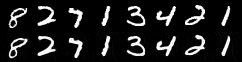

In [47]:
img

In [48]:
img.save('example_mnist.png')

In [49]:
sample_size = min(8, z.shape[0])
save_output = torch.clamp(z[:sample_size], -1., 1.).detach().cpu()
save_output = ((save_output + 1) / 2)
save_input = ((z[:sample_size] + 1) / 2).detach().cpu()

grid = make_grid(torch.cat([save_input, save_output], dim=0), nrow=sample_size)
img = torchvision.transforms.ToPILImage()(grid)

In [50]:
img

In [51]:
img.save('example_z_mnist.png')

In [52]:
torch.save(vqvae_lightning.model.state_dict(), 'vqvae_mnist.sd')
torch.save(vqvae_lightning.lpips.state_dict(), 'lpips_mnist.sd')
torch.save(vqvae_lightning.discriminator.state_dict(), 'discriminator_mnist.sd')

### Train LDM

In [53]:
from transformers import DistilBertModel, DistilBertTokenizer
from transformers import AutoModel, AutoTokenizer

In [54]:
tokenizer = AutoTokenizer.from_pretrained("prajjwal1/bert-tiny")
text_model = AutoModel.from_pretrained("prajjwal1/bert-tiny").eval()

In [55]:
for param in text_model.parameters():
    param.requires_grad = False

In [56]:
class MNISTConditionDataset(Dataset):
    def __init__(self, mnist_dataset, tokenizer):
        super().__init__()
        self.mnist_dataset = mnist_dataset
        self.tokenizer = tokenizer
        self.cond_drop_prob: float = 0.1

    def __getitem__(self, index: int) -> tuple:
        img, label = self.mnist_dataset[index]
        if np.random.rand() < self.cond_drop_prob:
            label = 10

        tokenized = self.tokenizer(
            str(label),
            return_tensors='pt',
            padding='max_length',
            max_length=8,
            truncation=True,
        )

        return img, tokenized['input_ids'][0], tokenized['attention_mask'][0]

    def __len__(self):
        return len(self.mnist_dataset)

In [57]:
train_dataset = MNISTConditionDataset(train_dataset, tokenizer)

## Loader

In [58]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

In [59]:
for batch in train_loader:
    break

In [60]:
batch[0].shape, batch[1].shape, batch[2].shape

(torch.Size([64, 1, 28, 28]), torch.Size([64, 8]), torch.Size([64, 8]))

## Train

In [61]:
scheduler = LinearNoiseScheduler(
    num_timesteps=1000,
    beta_start=0.0001,
    beta_end=0.02,
)

In [62]:
ldm_config = {
    'im_channels': 4,
    'down_channels': [64, 128, 128],
    'mid_channels': [128, 128],
    'up_channels': [128, 128, 64],
    't_emb_dim': 128,
    'down_sample': [False, False],
    'up_sample': [False, False],
    'num_down_layers': 2,
    'num_mid_layers': 2,
    'num_up_layers': 2,
    'norm_channels': 32,
    'attns': [True, True, True],
    'num_heads': 16,
    'conv_out_channels': 64,
    'context_dim': 128,
    'condition_config': {
        'condition_types': [ 'text' ],
        'text_condition_config': {
            'text_embed_model': 'bert',
            'train_text_embed_model': False,
            'text_embed_dim': 128,
            'cond_drop_prob': 0.1,
        }
    }
}

In [63]:
unet = Unet2(ldm_config)

In [64]:
print(f"The model has {count_parameters(unet):,} trainable parameters")

The model has 3,829,060 trainable parameters


In [65]:
vae_model = VQVAE(vqvae_config).eval()
vae_model.load_state_dict(torch.load('vqvae_mnist.sd'))
for param in vae_model.parameters():
    param.requires_grad = False

In [66]:
ddpm = DDPMLightning(unet, vae_model, text_model, scheduler, torch.nn.MSELoss(), 1e-4)

max_epochs = 10
accumulate_grad_batches = 1

In [67]:
trainer = pl.Trainer(
    accelerator='cuda',
    # logger=logger,
    # callbacks=[checkpoint_callback, lr_callback],
    max_epochs=max_epochs,
    accumulate_grad_batches=accumulate_grad_batches,
    precision="bf16-mixed",
    log_every_n_steps=1,
    enable_checkpointing=True,
    enable_progress_bar=True,
    gradient_clip_val=5,
    use_distributed_sampler=True,
)

Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [68]:
trainer.fit(
    ddpm,
    train_dataloaders=train_loader,
    # val_dataloaders=valid_loader,
)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | unet_model      | Unet2                | 3.8 M  | train
1 | vae_model       | VQVAE                | 14.9 M | eval 
2 | text_encoder    | BertModel            | 4.4 M  | eval 
3 | noise_scheduler | LinearNoiseScheduler | 0      | train
4 | criterion       | MSELoss              | 0      | train
-----------------------------------------------------------------
3.8 M     Trainable params
19.3 M    Non-trainable params
23.1 M    Total params
92.486    Total estimated model params size (MB)
295       Modules in train mode
270       Modules in eval mode


Training: |                                               | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


In [69]:
torch.save(ddpm.unet_model.state_dict(), 'ldm_mnist.sd')

## Sample

In [70]:
train_config = {
    'num_samples': 121,
    'im_channels': 1,
    'im_size': 28,
    'num_grid_rows': 11,
    'task_name': 'mnist',
}
diffusion_config = {
    'num_timesteps': 1000,
}
autoencoder_model_config = {
    'down_sample': [True, True],
    'z_channels': 4,
}
dataset_config = {
    'im_size': 28,
}

In [71]:
tokenized = tokenizer(
    list(map(str, list(range(11)))),
    return_tensors='pt',
    padding='max_length',
    max_length=8,
    truncation=True,
)

In [72]:
a = text_model(**tokenized).last_hidden_state

In [73]:
a = a.to('cuda')

In [74]:
def sample(
    unet_model,
    vae,
    scheduler,
    train_config,
    diffusion_config,
    autoencoder_model_config,
    dataset_config,
    device,
):
    """
    Sample stepwise by going backward one timestep at a time.
    We save the x0 predictions
    """
    im_size = dataset_config['im_size'] // 2 ** sum(autoencoder_model_config['down_sample'])
    xt = torch.randn((train_config['num_samples'],
                      autoencoder_model_config['z_channels'],
                      im_size,
                      im_size), device=device)

    save_count = 0
    for i in tqdm(reversed(range(diffusion_config['num_timesteps'])), total=1000):
        # Get prediction of noise
        noise_pred = unet_model(
            xt,
            torch.as_tensor(i, device=device).unsqueeze(0).repeat(121),
            a.repeat(11, 1, 1),
        )
        
        # Use scheduler to get x0 and xt-1
        xt, x0_pred = scheduler.sample_prev_timestep(xt, noise_pred, torch.as_tensor(i, device=device))

        # Save x0
        if i == 0:
            # Decode ONLY the final iamge to save time
            ims = vae.decode(xt)
        else:
            ims = xt
        
        ims = torch.clamp(ims, -1., 1.).detach().cpu()
        ims = (ims + 1) / 2
        grid = make_grid(ims, nrow=train_config['num_grid_rows'])
        img = torchvision.transforms.ToPILImage()(grid)

        if i == 0:
            if not os.path.exists(os.path.join(train_config['task_name'], 'samples')):
                os.mkdir(os.path.join(train_config['task_name'], 'samples'))
            img.save(os.path.join(train_config['task_name'], 'samples', 'x0_{}.png'.format(i)))
            img.close()

In [75]:
device = 'cuda'

In [76]:
unet.to(device).eval()
scheduler.to(device)
vae_model.to(device)
''

''

In [77]:
with torch.no_grad():
    sample(unet, vae_model, scheduler, train_config, diffusion_config, autoencoder_model_config, dataset_config, device)

  0%|          | 0/1000 [00:00<?, ?it/s]

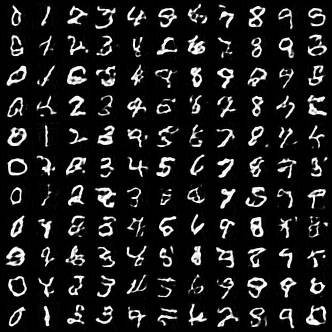

In [78]:
from PIL import Image
Image.open("mnist/samples/x0_0.png")